In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
X, y = df.drop(columns='Outcome'), df['Outcome']

                    Feature  Importance
1                   Glucose    0.269498
5                       BMI    0.151984
7                       Age    0.135391
6  DiabetesPedigreeFunction    0.101782
2             BloodPressure    0.093568
3             SkinThickness    0.090205
4                   Insulin    0.082889
0               Pregnancies    0.074684


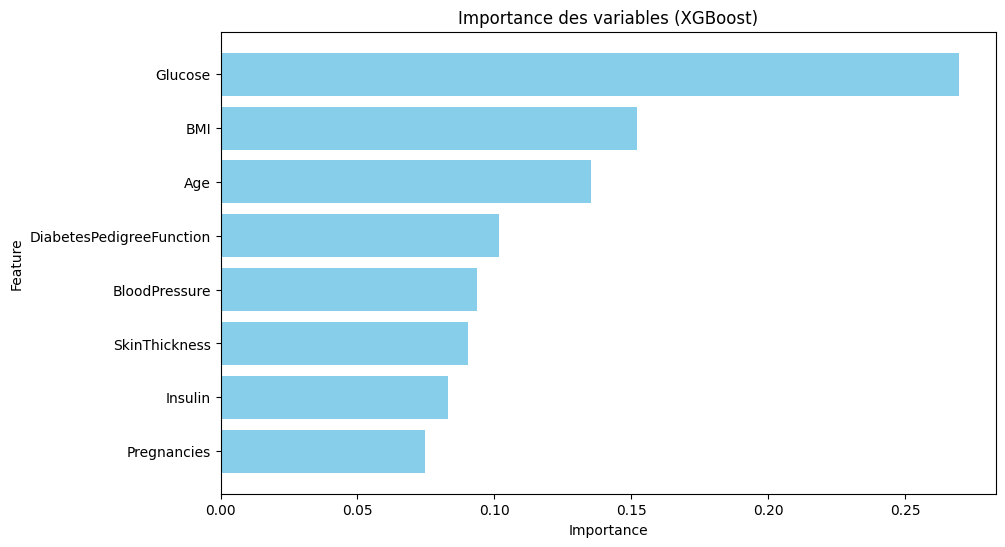

In [5]:
# Entraîner un modèle XGBoost
model = XGBClassifier(random_state=42)
model.fit(X, y)

# Obtenir les importances des variables
importances = model.feature_importances_
features = X.columns

# Créer un DataFrame pour organiser les résultats
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Afficher les résultats
print(feature_importance_df)

# Visualisation des importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance des variables (XGBoost)')
plt.gca().invert_yaxis()  # Inverser l'ordre pour que les plus importantes soient en haut
plt.show()

In [6]:
# Convertir en tensor pour PyTorch
X_tensor = torch.tensor(X.values).type(torch.float)
y_tensor = torch.tensor(y.values).type(torch.float)

X_tensor

tensor([[  6.0000, 148.0000,  72.0000,  ...,  33.6000,   0.6270,  50.0000],
        [  1.0000,  85.0000,  66.0000,  ...,  26.6000,   0.3510,  31.0000],
        [  8.0000, 183.0000,  64.0000,  ...,  23.3000,   0.6720,  32.0000],
        ...,
        [  5.0000, 121.0000,  72.0000,  ...,  26.2000,   0.2450,  30.0000],
        [  1.0000, 126.0000,  60.0000,  ...,  30.1000,   0.3490,  47.0000],
        [  1.0000,  93.0000,  70.0000,  ...,  30.4000,   0.3150,  23.0000]])

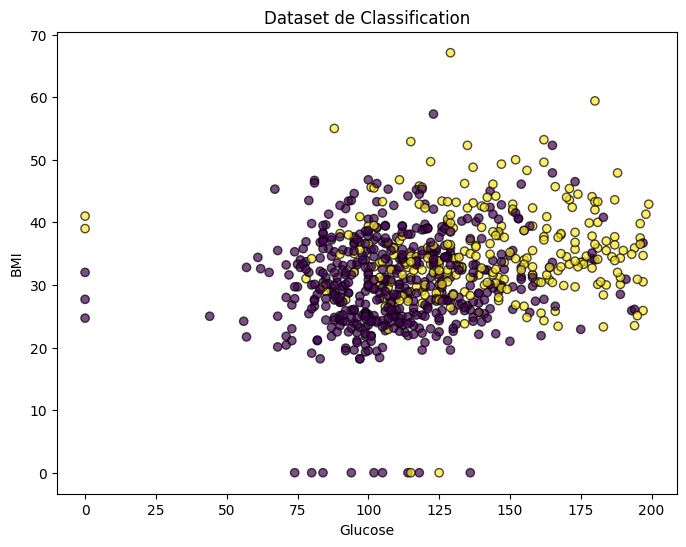

In [7]:
X, y = df[['Glucose', 'BMI']], df['Outcome']

# Convertir en tensor pour PyTorch
X_tensor = torch.tensor(X.values).type(torch.float)
y_tensor = torch.tensor(y.values).type(torch.long)

# Visualiser le dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Dataset de Classification")
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.show()

### Delete Outliers

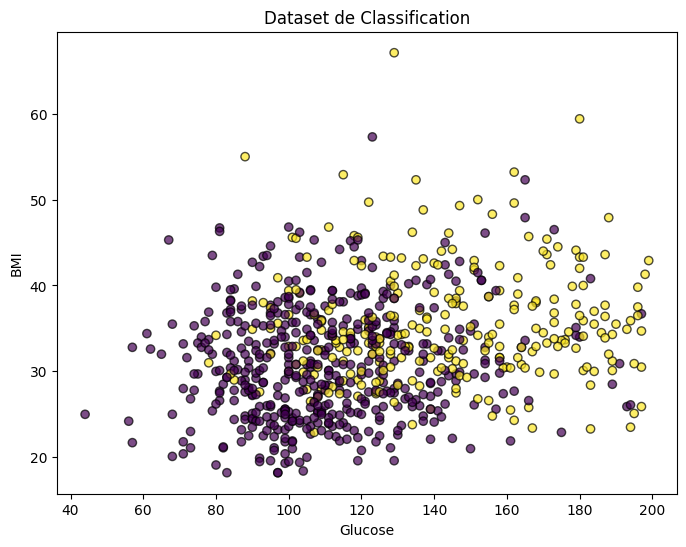

In [8]:
# Filtrer les échantillons où 'Glucose' et 'BMI' ne sont pas égaux à 0
mask = (X['Glucose'] != 0) & (X['BMI'] != 0)

# Appliquer le masque à X et y
X = X[mask]
y = y[mask]

# Convertir en tensor pour PyTorch
X_tensor = torch.tensor(X.values).type(torch.float)
y_tensor = torch.tensor(y.values).type(torch.long)

# Visualiser le dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Dataset de Classification")
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.show()

In [9]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.2):
        super(MLPWithDropout, self).__init__()
        
        hidden_dims = [input_dim] + hidden_dims

        self.layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Sequential(
            nn.Linear(hidden_dims[i-1], hidden_dims[i]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# Initialiser le modèle
model = MLPWithDropout(input_dim=2, hidden_dims=[64, 32], output_dim=2)

In [10]:
def get_entropy(prob: torch.Tensor):
    entropy = - prob * torch.log(prob) - (1 - prob) * torch.log(1 - prob)
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()

    return entropy

In [11]:
epochs = 2000
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Run training
for epoch in range(epochs):
    model.train()  # Passer le modèle en mode entraînement
    
    # Passer toutes les données d'un coup
    output = model(X_tensor)  # Prédiction du modèle

    # Conversion de la cible en one-hot
    target_one_hot = torch.zeros(X_tensor.size(0), 2)  # 2 est pour le nombre de classes
    target_one_hot[torch.arange(X_tensor.size(0)), y_tensor] = 1  # Conversion en one-hot
    
    # Calcul de la loss
    loss = nn.BCEWithLogitsLoss()(output, target_one_hot)
    
    # Calcul des gradients et mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Affichage de la loss pour chaque époque
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")


Epoch 1/2000 - Loss: 4.673690
Epoch 2/2000 - Loss: 6.125877
Epoch 3/2000 - Loss: 4.622799
Epoch 4/2000 - Loss: 3.082760
Epoch 5/2000 - Loss: 1.714002
Epoch 6/2000 - Loss: 1.898208
Epoch 7/2000 - Loss: 1.998705
Epoch 8/2000 - Loss: 1.497850
Epoch 9/2000 - Loss: 1.138067
Epoch 10/2000 - Loss: 0.874946
Epoch 11/2000 - Loss: 0.742119
Epoch 12/2000 - Loss: 0.718710
Epoch 13/2000 - Loss: 0.711037
Epoch 14/2000 - Loss: 0.699795
Epoch 15/2000 - Loss: 0.690992
Epoch 16/2000 - Loss: 0.690157
Epoch 17/2000 - Loss: 0.688694
Epoch 18/2000 - Loss: 0.683529
Epoch 19/2000 - Loss: 0.683788
Epoch 20/2000 - Loss: 0.683987
Epoch 21/2000 - Loss: 0.682777
Epoch 22/2000 - Loss: 0.681518
Epoch 23/2000 - Loss: 0.680924
Epoch 24/2000 - Loss: 0.679690
Epoch 25/2000 - Loss: 0.681089
Epoch 26/2000 - Loss: 0.677841
Epoch 27/2000 - Loss: 0.680807
Epoch 28/2000 - Loss: 0.678807
Epoch 29/2000 - Loss: 0.675634
Epoch 30/2000 - Loss: 0.676200
Epoch 31/2000 - Loss: 0.675693
Epoch 32/2000 - Loss: 0.674524
Epoch 33/2000 - L

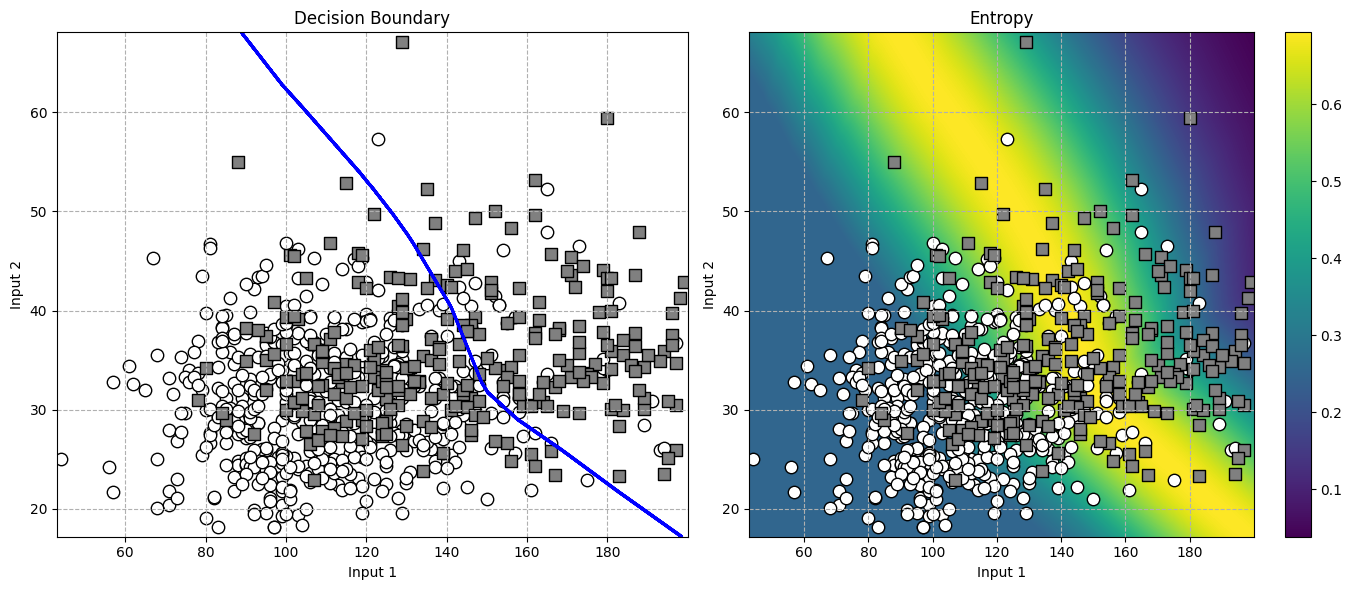

In [12]:
# Définir les limites de la grille en fonction de vos données
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

# Initialisation des graphiques avant la boucle des epochs
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

# Decision boundary
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel("Input 1")
ax1.set_ylabel("Input 2")
ax1.set_title("Decision Boundary")

# Entropy
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel("Input 1")
ax2.set_ylabel("Input 2")
ax2.set_title("Entropy")

# Après la fin de l'entraînement, effectuez le plot
model.eval()

# Décision et entropie pour la visualisation
output = model(data_meshgrid)  # Logits pour chaque point
prob = torch.softmax(output, dim=1)  # Probabilités pour chaque classe
prob_class_1 = prob[:, 1].view(xx.shape)  # Probabilité pour la classe 0
entropy = get_entropy(prob_class_1)  # Entropie basée sur les probabilités
pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Classe prédite

# Affichage de la frontière de décision
ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])

# Affichage de l'entropie
im = ax2.pcolormesh(xx, yy, entropy)  # Affichage de l'entropie
fig.colorbar(im, ax=ax2)

# Points de données (assurez-vous que y est une série ou un tenseur avec les bonnes dimensions)
for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
    _X = X[y == label]  # Filtrer les points par classe
    ax1.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)  # X est un DataFrame
    ax2.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)

ax1.grid(linestyle="--")
ax2.grid(linestyle="--")
plt.tight_layout()
plt.show()  # Affichage final du plot

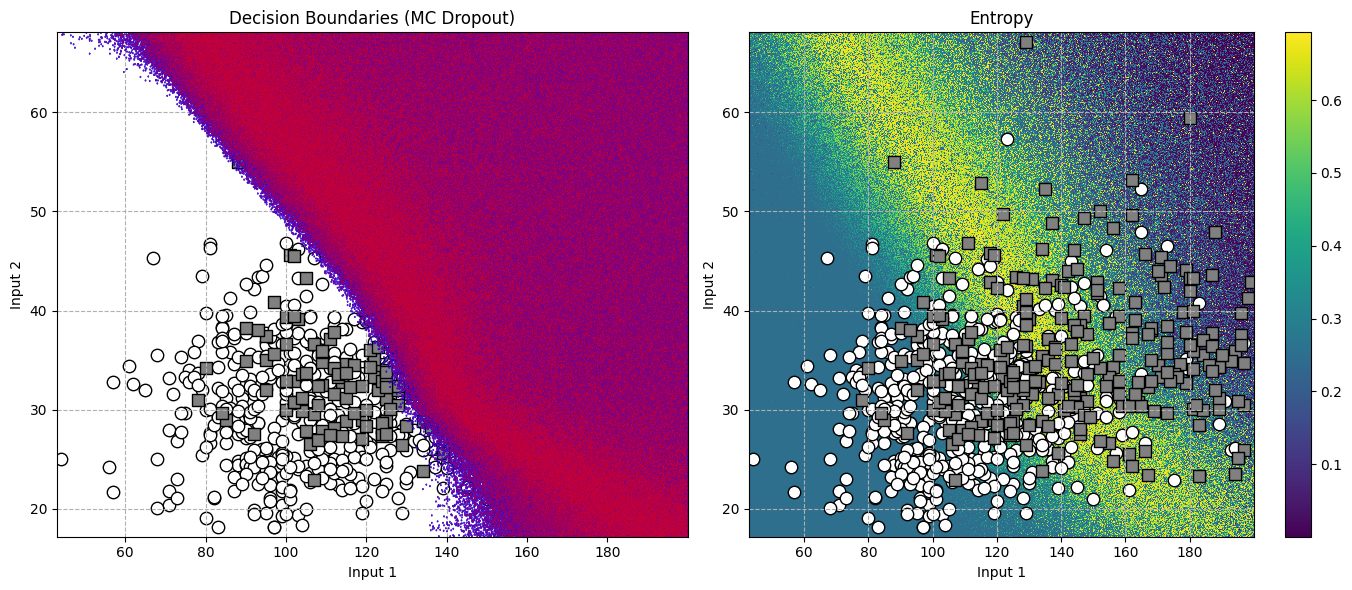

In [20]:
# Fonction pour activer le dropout en mode évaluation
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

# Définir les limites de la grille en fonction de vos données
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

# Initialisation des graphiques avant la boucle des epochs
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

# Decision boundary
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel("Input 1")
ax1.set_ylabel("Input 2")
ax1.set_title("Decision Boundaries (MC Dropout)")

# Entropy
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel("Input 1")
ax2.set_ylabel("Input 2")
ax2.set_title("Entropy")

# Après la fin de l'entraînement, effectuez le plot
model.eval()

# Activer le dropout en mode évaluation
enable_dropout(model)

# Nombre de passes pour MC Dropout
num_passes = 2
predictions = []

# Effectuer plusieurs passes pour obtenir les prédictions
for _ in range(num_passes):
    output = model(data_meshgrid)  # Logits pour chaque point
    prob = torch.softmax(output, dim=1)  # Probabilités pour chaque classe
    prob_class_1 = prob[:, 1].view(xx.shape)  # Probabilité pour la classe 1
    pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Classe prédite
    predictions.append(pred)

# Calculer la frontière de décision (moyenne des prédictions)
decision_boundaries = np.mean(predictions, axis=0)

# Affichage des différentes frontières de décision
for pred in predictions:
    ax1.contour(xx, yy, pred, colors="blue", linewidths=1, alpha=0.3)  # Afficher les frontières de décision de chaque passe

# Affichage de la frontière moyenne de décision
ax1.contour(xx, yy, decision_boundaries, colors="red", linewidths=0.5, alpha=0.2)  # Frontière moyenne (décision finale)

# Calcul de l'entropie moyenne basée sur la probabilité de la classe 1
entropy = get_entropy(prob_class_1)  # Entropie basée sur les probabilités de la classe 1
im = ax2.pcolormesh(xx, yy, entropy, shading="auto")  # Affichage de l'entropie
fig.colorbar(im, ax=ax2)

# Points de données (assurez-vous que y est une série ou un tenseur avec les bonnes dimensions)
for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
    _X = X[y == label]  # Filtrer les points par classe
    ax1.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)  # X est un DataFrame
    ax2.scatter(_X.iloc[:, 0], _X.iloc[:, 1], s=80, c=color, edgecolors="black", marker=marker)

ax1.grid(linestyle="--")
ax2.grid(linestyle="--")
plt.tight_layout()
plt.show()  # Affichage final du plot


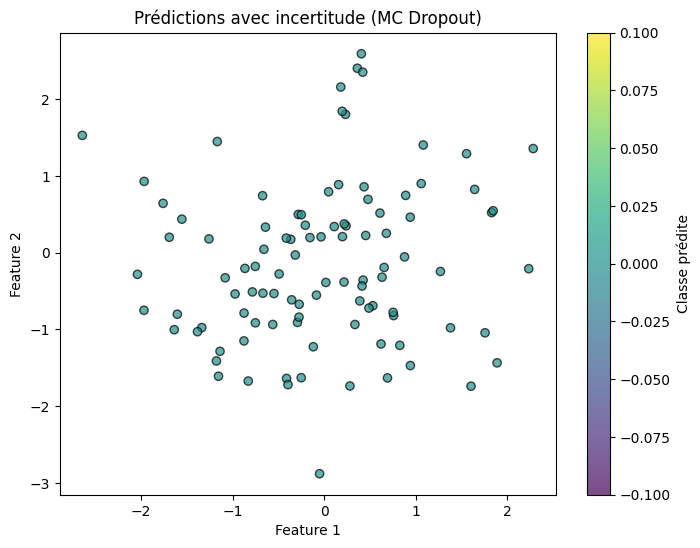

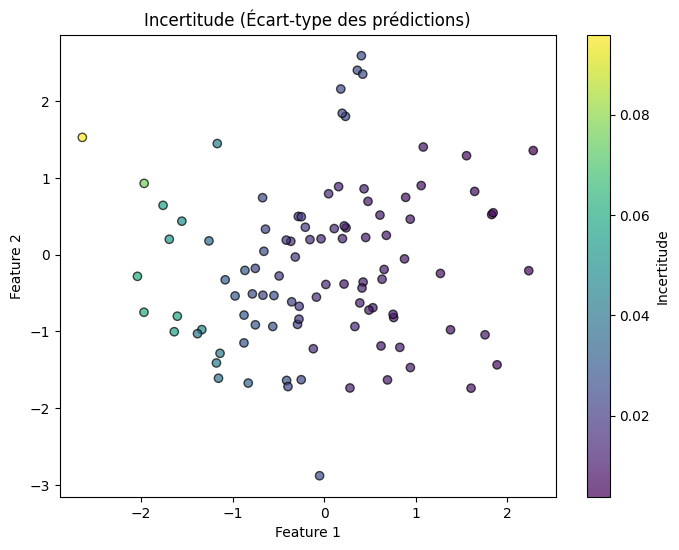

In [19]:
# Fonction pour faire des prédictions avec Dropout actif
def predict_with_uncertainty(f_model, x, n_iter=50):
    f_model.train()  # Garder Dropout actif
    preds = np.array([f_model(x).detach().numpy() for _ in range(n_iter)])
    return preds.mean(axis=0), preds.var(axis=0)

# Faire des prédictions stochastiques sur de nouvelles données
X_new = torch.randn(100, 2)  # Générer de nouvelles données aléatoires
mean_preds, var_preds = predict_with_uncertainty(model, X_new, n_iter=100)

# Visualiser les résultats
mean_probs = np.exp(mean_preds) / np.sum(np.exp(mean_preds), axis=1, keepdims=True)  # Appliquer softmax

# Tracer la prédiction moyenne et l'incertitude
plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=np.argmax(mean_probs, axis=1), cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Prédictions avec incertitude (MC Dropout)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Classe prédite")
plt.show()

# Tracer l'incertitude
uncertainty = np.sqrt(var_preds)  # Calculer l'écart-type
plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=uncertainty[:, 0], cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Incertitude (Écart-type des prédictions)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Incertitude")
plt.show()

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Fonction pour faire des prédictions avec incertitude (MC Dropout)
def predict_with_uncertainty(f_model, x, n_iter=50):
    f_model.train()  # Garder Dropout actif
    preds = np.array([f_model(x).detach().numpy() for _ in range(n_iter)])
    mean_preds = preds.mean(axis=0)
    conf_interval = 1.96 * preds.std(axis=0)  # Intervalle de confiance à 95%
    return mean_preds, conf_interval

# Créer un maillage couvrant l'espace des features (plage des données)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Faire des prédictions avec incertitude sur une grille de points
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
mean_preds, conf_interval = predict_with_uncertainty(model, grid_points, n_iter=100)

# Visualiser les intervalles de confiance
plt.figure(figsize=(8, 6))

# Tracer la carte de chaleur des prédictions moyennes (inverser les couleurs)
contour = plt.contourf(xx, yy, mean_preds[:, 0].reshape(xx.shape), alpha=0.8, cmap='viridis', vmin=mean_preds.min(), vmax=mean_preds.max())

# Tracer l'intervalle de confiance à 95% (échelle de couleur)
plt.contour(xx, yy, (mean_preds[:, 0].reshape(xx.shape) + conf_interval[:, 0].reshape(xx.shape)),
            levels=[0], colors='red', linewidths=1)
plt.contour(xx, yy, (mean_preds[:, 0].reshape(xx.shape) - conf_interval[:, 0].reshape(xx.shape)),
            levels=[0], colors='red', linewidths=1)

# Afficher les points du dataset original
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)

# Ajouter la barre de couleur (échelle de couleurs)
plt.colorbar(contour, label='Prédiction moyenne')

plt.title("Intervalles de Confiance des Prédictions (MC Dropout)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


InvalidIndexError: (slice(None, None, None), 0)